In [1]:
from utils import *
df = get_dataframe()

plt.rcParams.update({'font.size': 20})

In [2]:
df.columns

Index(['aiToolTypicalUsage', 'task_id', 'aihelpful', 'task_duration', 'model',
       'interface', 'n_tasks_completed', 'n_tasks_attempted',
       'n_tasks_skipped', 'task_completion_durations', 'mean_task_duration',
       'coding_time', 'code_history', 'TLX_frustration', 'TLX_performance',
       'TLX_temporal_demand', 'TLX_physical_demand', 'TLX_effort',
       'TLX_mental_demand', 'TLX_total_score', 'n_sugg_accepted',
       'n_sugg_shown', 'sugg_accept_rate', 'time_spent_verifying',
       'n_sugg_requested', 'n_sugg_accepted_requested',
       'sugg_accept_rate_requested', 'sugg_accept_rate_non_requested',
       'n_assistant_response', 'n_user_message', 'n_copy_code_button',
       'n_copy_from_chat', 'avg_copy_per_response', 'task_data',
       'prog_experience', 'python_experience', 'ai_experience', 'model_size',
       'model_name', 'programmer_id', 'zscore_mean_task_duration',
       'zscore_n_tasks_completed', 'model_clean_name'],
      dtype='object')

# Appendix D.1

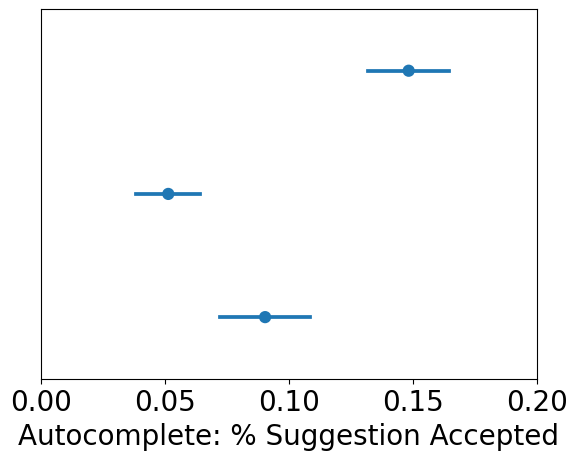

In [3]:
sns.pointplot(x="sugg_accept_rate", y="model_size", data=df.query("interface == 'autocomplete'"), linestyles="", errorbar="se")
plt.ylabel("")
plt.xlabel(r'Autocomplete: % Suggestion Accepted')
plt.xlim(0,0.2)
plt.tick_params(left = False , labelleft = False ) 
plt.savefig("num_sugg_accepted.pdf", format="pdf", bbox_inches="tight")

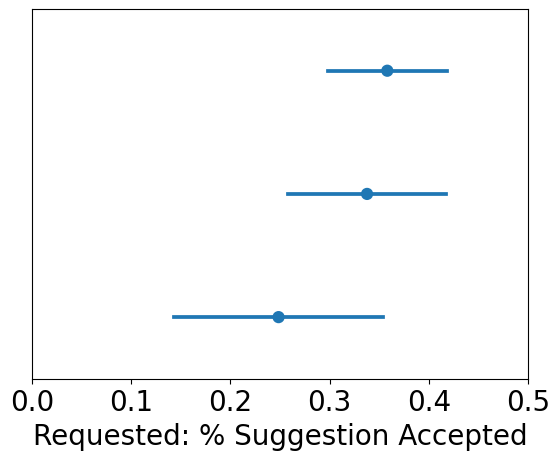

In [4]:
sns.pointplot(x="sugg_accept_rate_requested", y="model_size", data=df.query("interface == 'autocomplete'"), linestyles="", errorbar="se")
plt.ylabel("")
plt.xlim(0, 0.5)
plt.xlabel(r'Requested: % Suggestion Accepted')
#plt.yticks([0,1,2], ['GPT-3.5', 'CodeLlama-34b', 'CodeLlama-7b'])
plt.tick_params(left = False , labelleft = False ) 
plt.savefig("num_sugg_accepted_requested.pdf", format="pdf", bbox_inches="tight")

In [5]:
chat_df = pd.read_csv("../data/chat_data.csv")
chat_df

,request,response,copy_events,programmer_id,timestamp,model,task_name
0,[{'content': 'Show me an example in Python doi...,Certainly! Here's an example of using the `map...,[],63,0,GPT-3.5 (chat),sum_product
1,[{'content': 'How can I write a Python functio...,You can write a Python function to solve this ...,[],63,208809,GPT-3.5 (chat),triple_sum_to_zero
2,[{'content': 'How can I write a Python functio...,"Yes, there is a more efficient approach to sol...","[{'type': 'copy_button', 'copied': 'def has_ze...",63,225469,GPT-3.5 (chat),triple_sum_to_zero
3,[{'content': 'How do I one hot encode a column...,To one-hot encode a column into multiple colum...,[],63,502865,GPT-3.5 (chat),table_transform_named
4,[{'content': 'How do I one hot encode a column...,"To reorder columns in a DataFrame, you can use...",[],63,654757,GPT-3.5 (chat),table_transform_named
...,...,...,...,...,...,...,...
770,[{'content': 'how to get average of a list in ...,To calculate the variance of a list in Python...,"[{'type': 'copy_chat', 'copied': 'variance = s...",196,1561589,CodeLlama7b (chat),t_test
771,[{'content': 'how to get average of a list in ...,"In Python, you can get the square root of a n...",[],196,1660213,CodeLlama7b (chat),t_test
772,"[{'content': 'how to split by . ? or !', 'role...",You can split a string by a separator such as...,[],196,1743362,CodeLlama7b (chat),is_bored
773,"[{'content': 'how to split by . ? or !', 'role...","To split a string by multiple punctuations, y...",[],196,1776244,CodeLlama7b (chat),is_bored


In [6]:
###chat analysis

from collections import Counter
import ast

msg_lens = [] # length of indiv messages
all_words = {} #words used in indiv messages


df_chat = chat_df
for index, row in df_chat.iterrows():
    
    requests = ast.literal_eval(row['request'])
    
    if len(requests)>0:
        msg = requests[-1]['content']
        
        msg_lens.append(len(msg))
        
        words_in_msg = msg.split()
            
        for word in words_in_msg:
            clean_word = word.lower()

            if clean_word in all_words:
                all_words[clean_word]+=1
            else:
                all_words[clean_word]=1

Text(0.5, 0, 'Words appearing in chat msgs')

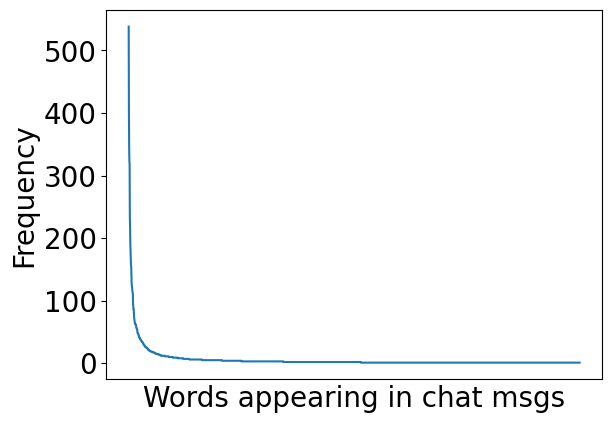

In [7]:
import pandas as pd
all_words_values = list(all_words.values())
all_words_values.sort(reverse = True)
x = [i for i in range(len(all_words_values))]

plt.plot(x, all_words_values)
plt.xticks([])
plt.ylabel("Frequency")
plt.xlabel("Words appearing in chat msgs")

Text(0, 0.5, 'Frequency')

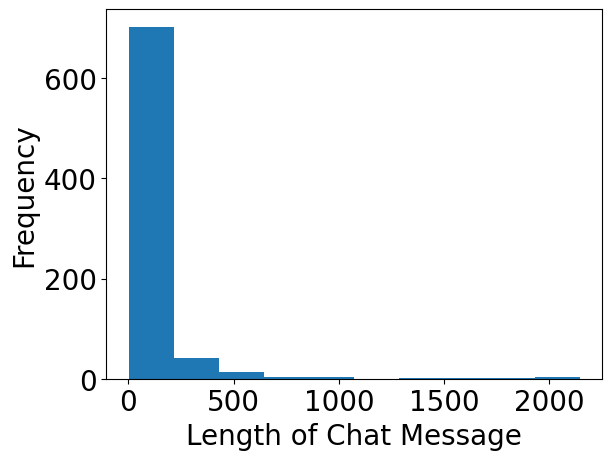

In [8]:
plt.hist(msg_lens)
plt.xlabel("Length of Chat Message")
plt.ylabel("Frequency")

In [9]:
msg_per = [] #number of messages sent for a task
msg_per_task = {}

for programmer in chat_df['programmer_id'].unique():
    chat_df_subset = chat_df[chat_df['programmer_id']==programmer]
    
    msg_per_chat = Counter(chat_df_subset['task_name'])
    
    for task in msg_per_chat:
        msg_per.append(msg_per_chat[task])
        
        if task in msg_per_task:
            msg_per_task[task].append(msg_per_chat[task])
        else:
            msg_per_task[task] = [msg_per_chat[task]]
    
    

Text(0, 0.5, 'Frequency')

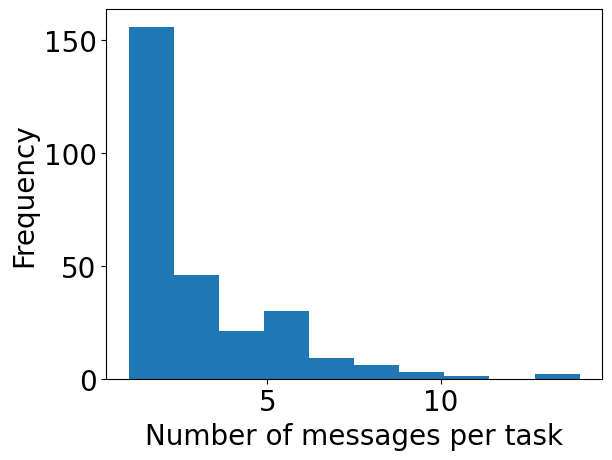

In [10]:
plt.hist(msg_per)
plt.xlabel("Number of messages per task")
plt.ylabel("Frequency")

In [11]:
task_display_order = ["sum_product", 
                      "t_test", "table_transform_named", "table_transform_unnamed1", "table_transform_unnamed2", 
                      "tokenizer", "calculator", "login_authenticator", "retriever",
                      "even_odd_count", "triple_sum_to_zero", "encode_message", "is_bored", "is_multiply_prime", "count_nums", "order_by_points", "event_scheduler"]

task_mapper = dict(zip(task_display_order, ["tutorial"]+["data_manipulation"]*4+["edit_code"]*4+["puzzles"]*8))

task_comb_results = {"tutorial" :[], "data_manipulation":[], "edit_code":[], "puzzles":[]}
for task in msg_per_task:
    
    act_task = task_mapper[task]
    task_comb_results[act_task] += msg_per_task[task]

tasks = []
msgs = []

for task in task_comb_results:
    tasks += [task]*len(task_comb_results[task])
    msgs += task_comb_results[task]

df_task_level = pd.DataFrame({"task_category":tasks, "num_msg_sent":msgs})
df_task_level.task_category = pd.Categorical(df_task_level.task_category, 
                      categories=["puzzles", "data_manipulation", "edit_code"])

([<matplotlib.axis.YTick at 0x7fbed968cc70>,
 [Text(0, 0, 'Algorithmic Problems'),
  Text(0, 1, 'Data Manipulation'),
  Text(0, 2, 'Edit/Augment Code')])

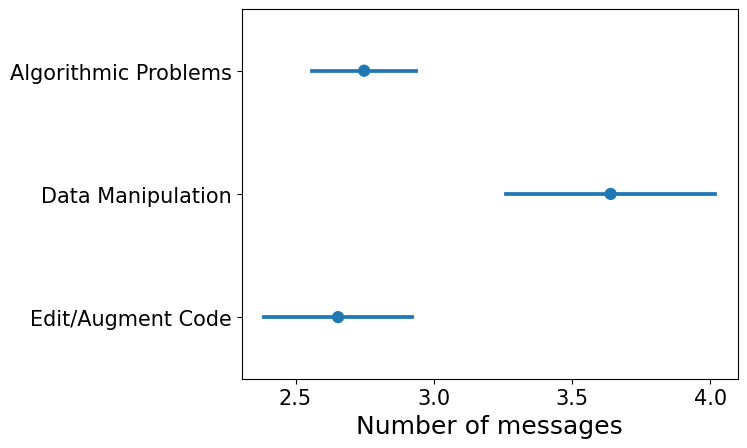

In [12]:
sns.pointplot(y="task_category", x="num_msg_sent", data=df_task_level.query("task_category != 'tutorial'"), linestyles="", errorbar="se")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Number of messages", fontsize=18)
plt.ylabel("")
plt.yticks([0, 1, 2], ['Algorithmic Problems', 'Data Manipulation', 'Edit/Augment Code'])

# Appendix D.2

In [13]:
outcome_cols = ["n_tasks_completed", "mean_task_duration"]
for task_id in df["task_id"].unique():
    df.loc[df["task_id"] == task_id, ["ctl_" + x for x in outcome_cols]] = StandardScaler().fit_transform(df.loc[df["task_id"] == task_id, outcome_cols])

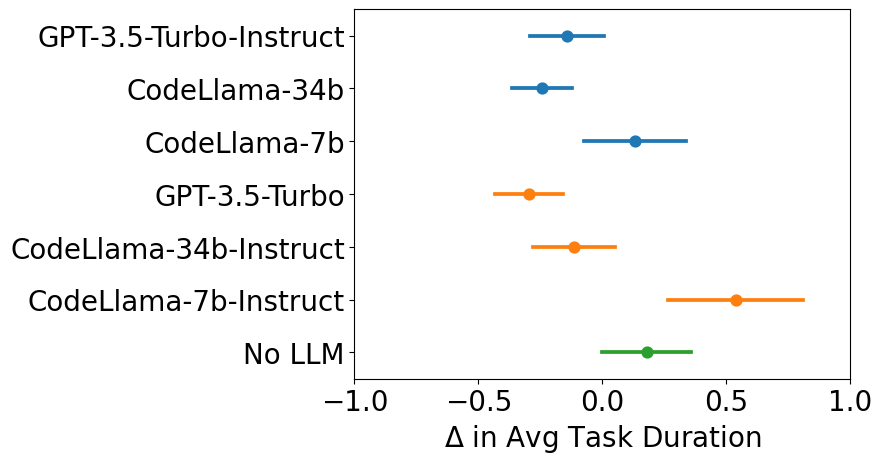

In [22]:
sns.pointplot(x="ctl_mean_task_duration", y="model", data=df, linestyles="", hue="interface", errorbar="se")
plt.ylabel("")
plt.xlabel(r'$\Delta$ in Avg Task Duration')
plt.xlim(-1, 1)
plt.yticks([0, 1, 2,3,4,5,6], ['GPT-3.5-Turbo-Instruct', 'CodeLlama-34b', 'CodeLlama-7b', 'GPT-3.5-Turbo', 'CodeLlama-34b-Instruct', 'CodeLlama-7b-Instruct', 'No LLM'])
plt.legend([],[], frameon=False)

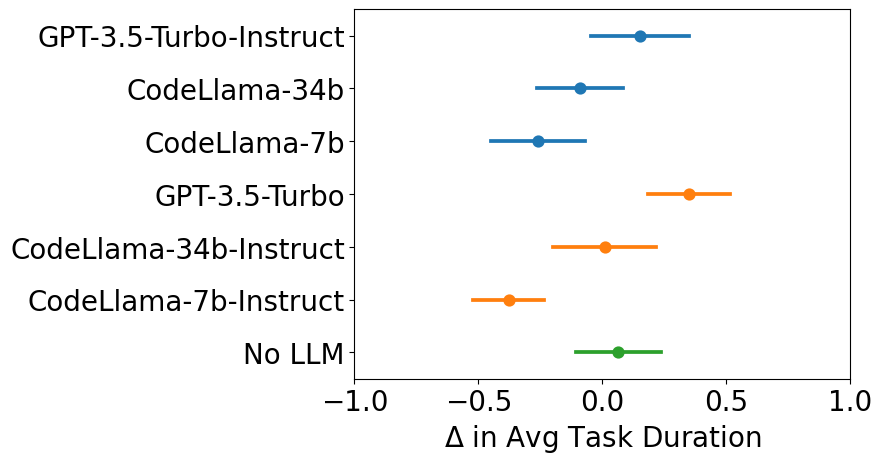

In [23]:
sns.pointplot(x="ctl_n_tasks_completed", y="model", data=df, linestyles="", hue="interface", errorbar="se")
plt.ylabel("")
plt.xlabel(r'$\Delta$ in Avg Task Duration')
plt.xlim(-1, 1)
plt.yticks([0, 1, 2,3,4,5,6], ['GPT-3.5-Turbo-Instruct', 'CodeLlama-34b', 'CodeLlama-7b', 'GPT-3.5-Turbo', 'CodeLlama-34b-Instruct', 'CodeLlama-7b-Instruct', 'No LLM'])
plt.legend([],[], frameon=False)

# Appendix D.3

In [14]:
list_task_level_dfs = []

import ast

for row in df.itertuples():
        
    temp = ast.literal_eval(row.task_data)
    df_temp = pd.DataFrame(temp.values()).assign(model=row.model, interface=row.interface, model_size=row.model_size, 
                                                          task_set=temp.keys())
    list_task_level_dfs.append(df_temp)
    
    
df_task_level = pd.concat(list_task_level_dfs, ignore_index=True).assign(has_ai = lambda x: x.model != "nomodel").query("time_in_task < 30*60 and name != 'event_scheduler'").reset_index()

In [15]:
task_display_order = ["sum_product", 
                      "t_test", "table_transform_named", "table_transform_unnamed1", "table_transform_unnamed2", 
                      "tokenizer", "calculator", "login_authenticator", "retriever",
                      "even_odd_count", "triple_sum_to_zero", "encode_message", "is_bored", "is_multiply_prime", "count_nums", "order_by_points"]

df_task_level["ordered_name"] = pd.Categorical(df_task_level["name"], categories=task_display_order, ordered=True)

df_task_level["task_category"] = df_task_level["name"].map(dict(zip(task_display_order, ["tutorial"]+["data_manipulation"]*4+["edit_code"]*4+["puzzles"]*7)))

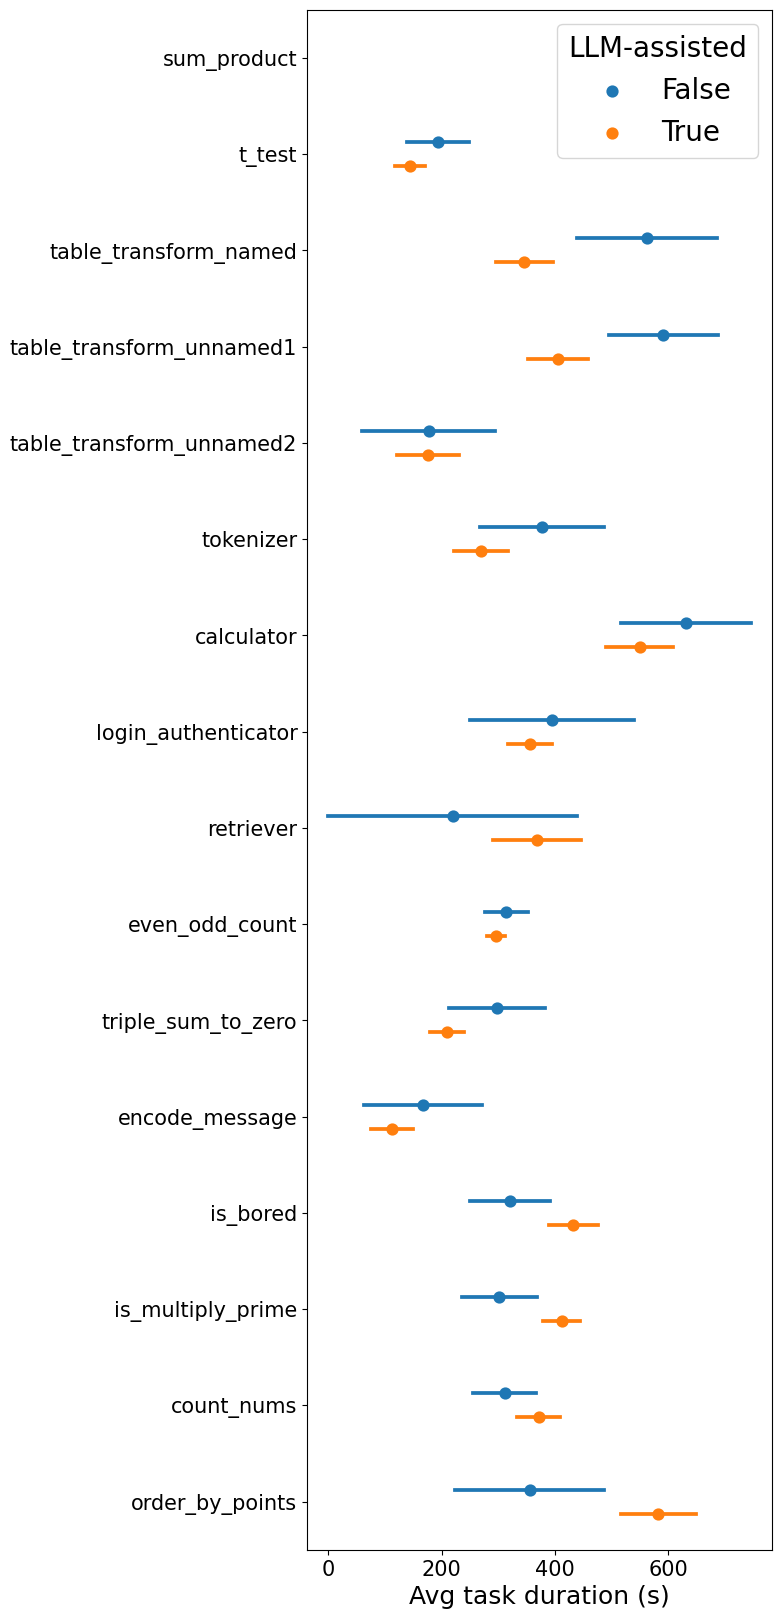

In [16]:
plt.figure(figsize=(6,20))
sns.pointplot(y="ordered_name", x="time_in_task", hue="has_ai", dodge=0.25, data=df_task_level.query("task_category != 'tutorial'"), linestyles="", errorbar="se")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Avg task duration (s)", fontsize=18)
plt.ylabel("")
plt.legend(title='LLM-assisted')

# Appendix D.5

In [17]:
df_TLX = df[['TLX_frustration', 'TLX_performance',
       'TLX_temporal_demand', 'TLX_physical_demand', 'TLX_effort',
       'TLX_mental_demand','model']]

df_TLX.groupby(by=["model"]).mean()

,TLX_frustration,TLX_performance,TLX_temporal_demand,TLX_physical_demand,TLX_effort,TLX_mental_demand
model,,,,,,
autocomplete_gpt35,10.093750,9.281250,12.187500,4.937500,10.875000,12.093750
autocomplete_llama34,13.535714,7.964286,11.178571,5.178571,10.857143,10.928571
autocomplete_llama7,11.884615,6.500000,13.884615,4.884615,10.653846,14.500000
chat_gpt35,8.114286,9.114286,12.742857,4.714286,11.800000,11.371429
chat_llama34,11.040000,8.000000,13.440000,5.160000,11.400000,12.880000
chat_llama7,9.535714,7.428571,12.571429,6.750000,11.928571,11.821429
nomodel,9.615385,7.564103,13.512821,5.948718,11.794872,12.102564


# Appendix D.7

[141.338, 110.108, 452.533, 340.053, 217.011, 234.205, 183.021]
[243.746, 425.801, 86.025, 840.47]
[137.493, 134.873, 226.801, 269.65, 261.069, 146.12, 155.127, 558.661]
[285.445, 129.916, 261.778, 695.218]
[115.316, 226.867, 639.899, 208.59]
[176.118, 292.668, 528.917, 356.693]
[191.283, 146.457, 208.015, 273.293, 378.161, 319.032, 331.631]
[332.851, 127.053, 508.808, 386.152, 249.752, 244.011]
[120.316, 357.852, 1017.172]
[555.062, 615.117, 188.191]
[47.266, 290.58, 422.632, 556.172, 396.323, 293.853]
[249.316, 175.612, 633.999]
[138.172, 120.204, 368.797, 695.994]
[247.406, 275.673]
[200.967, 325.892, 1042.348]
[272.605]
[104.088, 668.771]
[173.591, 123.025, 443.174, 195.484, 497.137]
[193.567, 85.518, 237.805, 385.91, 1.502, 482.824]
[50.557, 62.204, 421.424, 306.748, 194.054, 174.066, 268.407, 115.787]
[241.399, 56.497]
[374.813, 731.128]
[71.077, 198.814]
[193.876, 186.649, 218.336, 599.868, 570.053]
[184.367, 389.776, 241.324]
[117.118, 111.46, 101.571, 657.315]
[78.158, 191.884

Text(264.358, 102.60000000000001, 'Median')

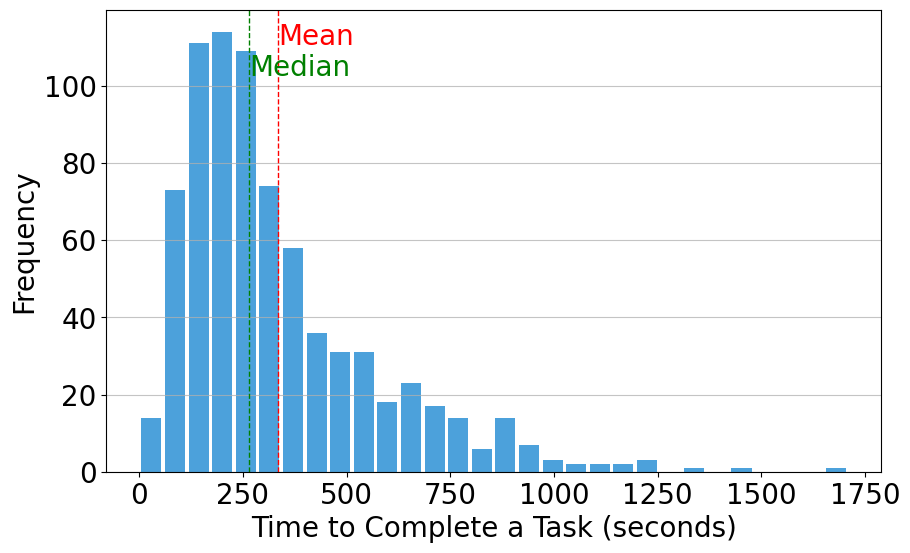

In [18]:
task_times = []

for item in df['task_completion_durations']:
    if 'nan' not in item:
        print(item)
        task_times += ast.literal_eval(item)


# Calculating statistics
mean_time = np.nanmean(task_times)
std_time = np.nanstd(task_times)
min_time = np.nanmin(task_times)
max_time = np.nanmax(task_times)
median_time = np.nanmedian(task_times)

# Outputting statistics for clarity
print(f'mean time to complete task: {mean_time}')
print(f'std time to complete task: {std_time}')
print(f'min time to complete task: {min_time}')
print(f'max time to complete task: {max_time}')
print(f'median time to complete task: {median_time}')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(task_times, bins='auto', color='#007acc', alpha=0.7, rwidth=0.85)
ax.grid(axis='y', alpha=0.75)
ax.set_xlabel('Time to Complete a Task (seconds)')
ax.set_ylabel('Frequency')
#ax.set_title('Histogram of Task Completion Times')

# Overlaying summary statistics
ax.axvline(mean_time, color='r', linestyle='dashed', linewidth=1)
ax.text(mean_time, max(n)*0.97, 'Mean', rotation=0, color='r')

ax.axvline(median_time, color='g', linestyle='dashed', linewidth=1)
ax.text(median_time, max(n)*0.9, 'Median', rotation=0, color='g')


